In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MAE: 7.66
MSE: 77.83
RMSE: 8.82
R²: -0.05


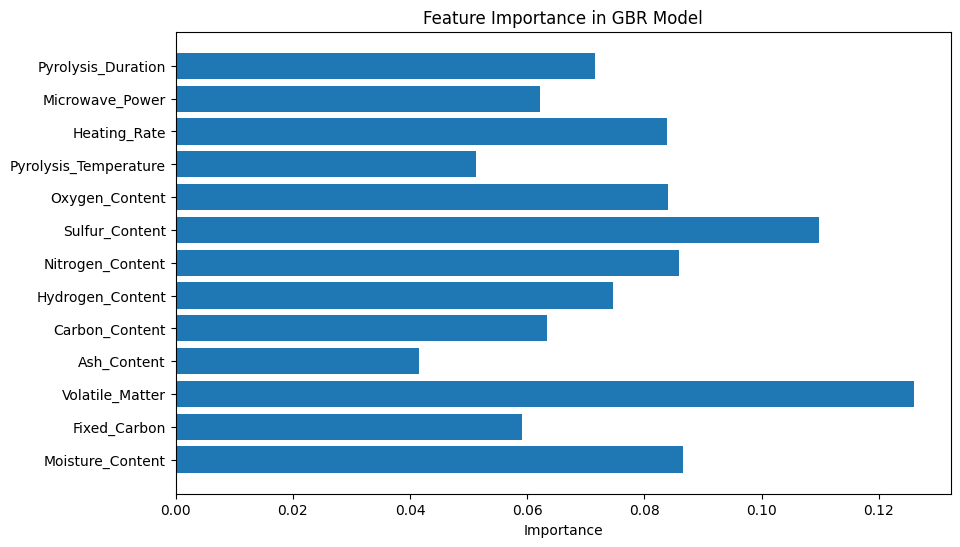

In [2]:
#Paper 1

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

# Step 1: Create a pseudo-dataset based on the parameters mentioned
np.random.seed(42)

n_samples = 1000  # Number of samples
dataset = pd.DataFrame({
    'Moisture_Content': np.random.uniform(5, 20, n_samples),
    'Fixed_Carbon': np.random.uniform(10, 30, n_samples),
    'Volatile_Matter': np.random.uniform(50, 80, n_samples),
    'Ash_Content': np.random.uniform(1, 10, n_samples),
    'Carbon_Content': np.random.uniform(30, 60, n_samples),
    'Hydrogen_Content': np.random.uniform(5, 10, n_samples),
    'Nitrogen_Content': np.random.uniform(0.5, 2.5, n_samples),
    'Sulfur_Content': np.random.uniform(0.1, 1.5, n_samples),
    'Oxygen_Content': np.random.uniform(20, 40, n_samples),
    'Pyrolysis_Temperature': np.random.uniform(400, 800, n_samples),
    'Heating_Rate': np.random.uniform(5, 50, n_samples),
    'Microwave_Power': np.random.uniform(100, 1000, n_samples),
    'Pyrolysis_Duration': np.random.uniform(10, 30, n_samples),
    'Bio_oil_Yield': np.random.uniform(20, 50, n_samples)  # Target variable
})

# Step 2: Preprocessing (Normalize the features)
X = dataset.drop('Bio_oil_Yield', axis=1)
y = dataset['Bio_oil_Yield']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Hyperparameter tuning (using randomized search)
param_dist = {
    'n_estimators': np.arange(100, 500),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(2, 10),
    'subsample': np.linspace(0.7, 1.0, 5)
}

random_search = RandomizedSearchCV(gbr, param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best model
best_gbr = random_search.best_estimator_

# Step 5: Evaluate the model
y_pred_train = best_gbr.predict(X_train)
y_pred_test = best_gbr.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

# Step 6: Feature Importance Analysis
feature_importances = best_gbr.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importance in GBR Model')
plt.show()

# Step 7: Partial Dependence Plot (PDP) for Pyrolysis Temperature using scikit-learn
PartialDependenceDisplay.from_estimator(best_gbr, X_test, [X.columns.get_loc("Pyrolysis_Temperature")])
plt.show()

# Step 8: SHAP Analysis
explainer = shap.Explainer(best_gbr)
shap_values = explainer(X_test)

# Summary plot for SHAP
shap.summary_plot(shap_values, X_test, feature_names=features)


Training Decision Tree...
Decision Tree Performance:
MAE: 9.86, MSE: 145.83, RMSE: 12.08, R²: -0.93
----------------------------------------
Training SVR...
SVR Performance:
MAE: 7.89, MSE: 84.97, RMSE: 9.22, R²: -0.12
----------------------------------------
Training Gradient Boosting...
Gradient Boosting Performance:
MAE: 8.22, MSE: 93.25, RMSE: 9.66, R²: -0.23
----------------------------------------
Training Gaussian Process...


The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.


Gaussian Process Performance:
MAE: 10.14, MSE: 148.19, RMSE: 12.17, R²: -0.96
----------------------------------------
Training Neural Network...


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


Neural Network Performance:
MAE: 8.67, MSE: 110.13, RMSE: 10.49, R²: -0.46
----------------------------------------


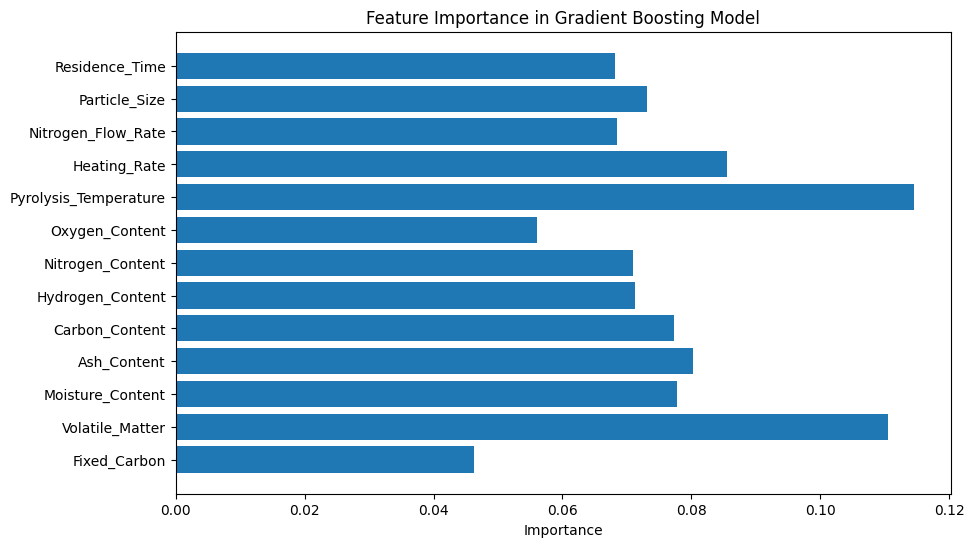

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SVR: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}


In [3]:
#Paper 4

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# Step 1: Generate a random dataset based on the paper's parameters
np.random.seed(42)
n_samples = 500  # Adjust based on your system's capacity

dataset = pd.DataFrame({
    'Fixed_Carbon': np.random.uniform(10, 30, n_samples),
    'Volatile_Matter': np.random.uniform(50, 80, n_samples),
    'Moisture_Content': np.random.uniform(5, 20, n_samples),
    'Ash_Content': np.random.uniform(1, 10, n_samples),
    'Carbon_Content': np.random.uniform(30, 60, n_samples),
    'Hydrogen_Content': np.random.uniform(5, 10, n_samples),
    'Nitrogen_Content': np.random.uniform(0.5, 2.5, n_samples),
    'Oxygen_Content': np.random.uniform(20, 40, n_samples),
    'Pyrolysis_Temperature': np.random.uniform(400, 800, n_samples),
    'Heating_Rate': np.random.uniform(5, 50, n_samples),
    'Nitrogen_Flow_Rate': np.random.uniform(50, 200, n_samples),
    'Particle_Size': np.random.uniform(0.1, 5, n_samples),
    'Residence_Time': np.random.uniform(10, 60, n_samples),
    'Bio_oil_Yield': np.random.uniform(20, 50, n_samples)  # Target variable
})

# Step 2: Preprocessing (Standardize the features)
X = dataset.drop('Bio_oil_Yield', axis=1)
y = dataset['Bio_oil_Yield']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Define multiple ML models

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Support Vector Regressor (SVR)
svr = SVR(kernel='rbf')

# Ensemble Tree: Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Gaussian Process Regressor (GPR)
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Artificial Neural Network (ANN)
ann = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=1000)

# Step 5: Train the models

models = {
    "Decision Tree": dt_reg,
    "SVR": svr,
    "Gradient Boosting": gbr,
    "Gaussian Process": gpr,
    "Neural Network": ann
}

# Train each model and store predictions
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}
    print(f"{name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    print('-' * 40)

# Step 6: Feature Importance for Tree-based Models
if 'Gradient Boosting' in models:
    feature_importances = models['Gradient Boosting'].feature_importances_
    features = X.columns

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(features, feature_importances)
    plt.xlabel('Importance')
    plt.title('Feature Importance in Gradient Boosting Model')
    plt.show()

# Step 7: SHAP Analysis for Model Interpretation
# Here we use the Gradient Boosting model as an example
explainer = shap.Explainer(models['Gradient Boosting'])
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# Step 8: Hyperparameter Optimization (Grid Search for SVR)
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Display the best parameters
print(f'Best parameters for SVR: {grid_search.best_params_}')


Training Random Forest...
Random Forest Performance:
MAE: 7.63, MSE: 75.81, RMSE: 8.71, R²: -0.04
----------------------------------------
Training Gradient Boosting...
Gradient Boosting Performance:
MAE: 7.93, MSE: 82.25, RMSE: 9.07, R²: -0.13
----------------------------------------
Training SVR...
SVR Performance:
MAE: 7.54, MSE: 73.49, RMSE: 8.57, R²: -0.01
----------------------------------------
Training Neural Network...


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


Neural Network Performance:
MAE: 8.48, MSE: 99.04, RMSE: 9.95, R²: -0.36
----------------------------------------
Training Linear Regression...
Linear Regression Performance:
MAE: 7.59, MSE: 73.93, RMSE: 8.60, R²: -0.02
----------------------------------------


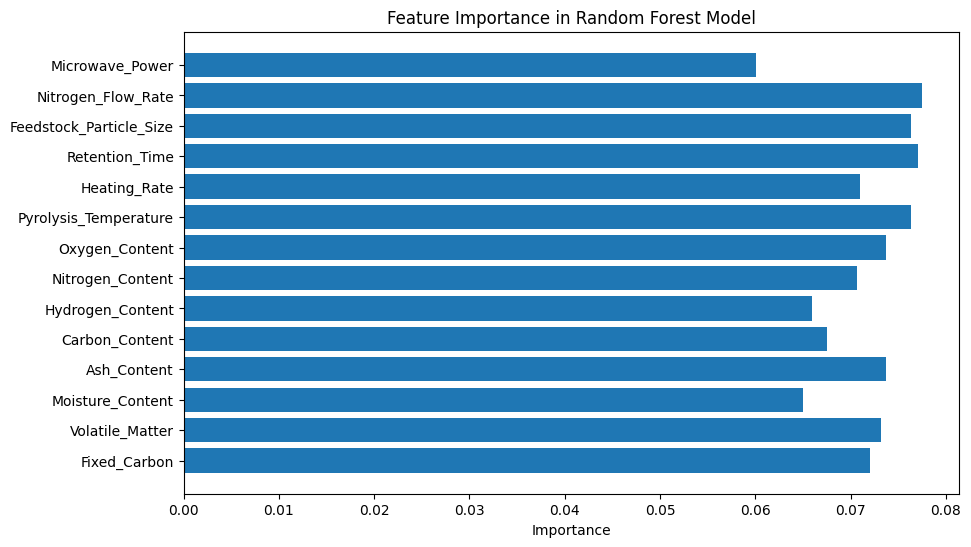

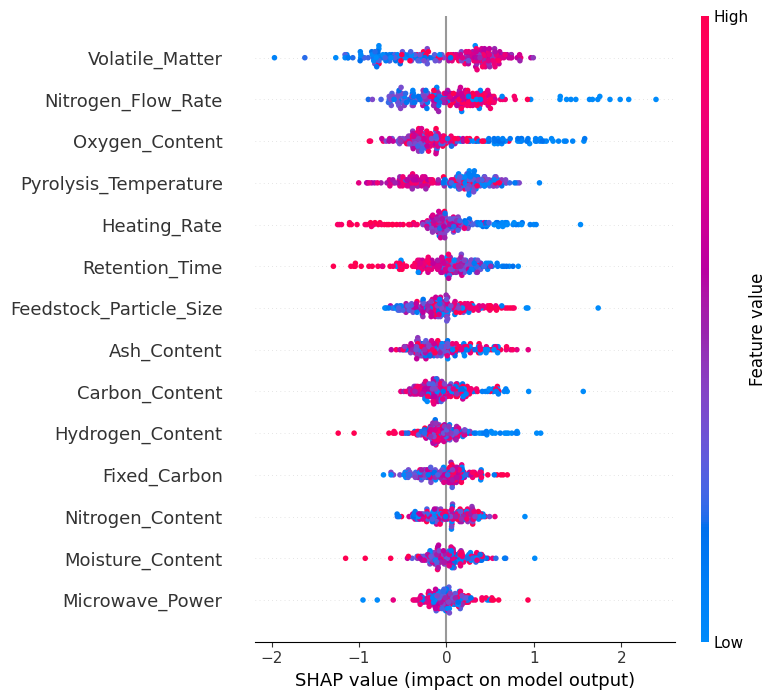

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SVR: {'C': 0.1, 'epsilon': 0.3, 'kernel': 'rbf'}


In [4]:
#Paper 5

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# Step 1: Generate a random dataset based on the parameters mentioned in the paper
np.random.seed(42)
n_samples = 1000  # Number of samples

dataset = pd.DataFrame({
    'Fixed_Carbon': np.random.uniform(10, 30, n_samples),
    'Volatile_Matter': np.random.uniform(50, 80, n_samples),
    'Moisture_Content': np.random.uniform(5, 20, n_samples),
    'Ash_Content': np.random.uniform(1, 10, n_samples),
    'Carbon_Content': np.random.uniform(30, 60, n_samples),
    'Hydrogen_Content': np.random.uniform(5, 10, n_samples),
    'Nitrogen_Content': np.random.uniform(0.5, 2.5, n_samples),
    'Oxygen_Content': np.random.uniform(20, 40, n_samples),
    'Pyrolysis_Temperature': np.random.uniform(400, 800, n_samples),
    'Heating_Rate': np.random.uniform(5, 50, n_samples),
    'Retention_Time': np.random.uniform(10, 60, n_samples),
    'Feedstock_Particle_Size': np.random.uniform(0.1, 5, n_samples),
    'Nitrogen_Flow_Rate': np.random.uniform(50, 200, n_samples),
    'Microwave_Power': np.random.uniform(100, 1000, n_samples),
    'Bio_oil_Yield': np.random.uniform(20, 50, n_samples)  # Target variable
})

# Step 2: Preprocessing (Standardize the features)
X = dataset.drop('Bio_oil_Yield', axis=1)
y = dataset['Bio_oil_Yield']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train Multiple ML Models

# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(random_state=42)

# Support Vector Regressor (SVR)
svr_reg = SVR(kernel='rbf')

# Artificial Neural Network (ANN)
ann_reg = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=1000)

# Linear Regression
lr_reg = LinearRegression()

# Step 5: Fit the models and store predictions
models = {
    "Random Forest": rf_reg,
    "Gradient Boosting": gb_reg,
    "SVR": svr_reg,
    "Neural Network": ann_reg,
    "Linear Regression": lr_reg
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}
    print(f"{name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    print('-' * 40)

# Step 6: Feature Importance for Tree-based Models (Random Forest)
if 'Random Forest' in models:
    feature_importances = models['Random Forest'].feature_importances_
    features = X.columns

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(features, feature_importances)
    plt.xlabel('Importance')
    plt.title('Feature Importance in Random Forest Model')
    plt.show()

# Step 7: SHAP Analysis for Model Interpretation
# Use SHAP for Random Forest as an example
explainer = shap.Explainer(models['Random Forest'])
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# Step 8: Hyperparameter Optimization Example (Grid Search for SVR)
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Display the best parameters
print(f'Best parameters for SVR: {grid_search.best_params_}')


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 6
[LightGBM] [Info] Start training from score 40.443119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100


I0000 00:00:1729683690.426254      74 service.cc:145] XLA service 0x7d3780002af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729683690.426315      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1737.5161
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1613.9890 
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1413.2563 
Epoch 4/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1252.7930

I0000 00:00:1729683691.348431      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1212.2689 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 911.6719 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 571.5718 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 259.0245 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107.0108 
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.5323 
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.3515 
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.0199 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.5625 
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.7630 
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52.5353 
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.7741 
Epoch 16/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52.7340 
Epoch 17/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.6345 
Epoch 18/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

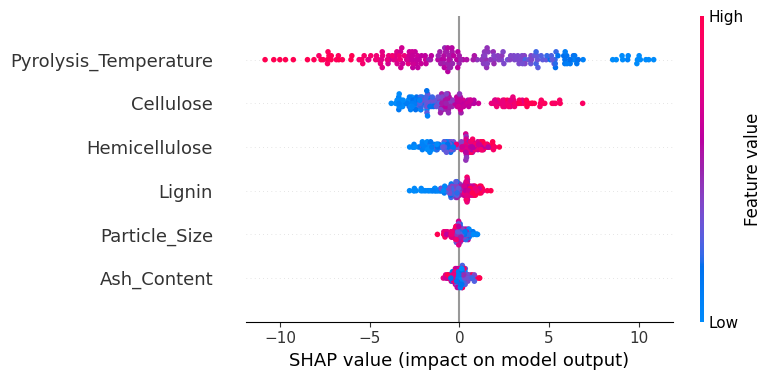

In [5]:
#Paper 7

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import shap

# Step 1: Create a better random dataset with correlations and realistic ranges
np.random.seed(42)
n_samples = 1000

# Generate biomass composition with interdependencies
cellulose = np.random.uniform(30, 60, n_samples)
hemicellulose = np.random.uniform(10, 30, n_samples)
lignin = np.random.uniform(15, 30, n_samples)
# The sum of these should reflect total biomass (introduce some randomness)
ash_content = np.random.uniform(1, 10, n_samples)

# Generate pyrolysis conditions with more realistic distributions
pyrolysis_temp = np.random.normal(600, 50, n_samples)  # centered around 600°C
particle_size = np.random.normal(2.5, 0.5, n_samples)  # centered around 2.5mm

# Bio-oil yield is influenced by these factors
bio_oil_yield = (
    0.3 * cellulose + 
    0.2 * hemicellulose + 
    0.15 * lignin + 
    0.1 * (800 - pyrolysis_temp) + 
    0.05 * particle_size + 
    np.random.normal(0, 5, n_samples)  # add some noise
)

# Create a DataFrame
dataset = pd.DataFrame({
    'Cellulose': cellulose,
    'Hemicellulose': hemicellulose,
    'Lignin': lignin,
    'Ash_Content': ash_content,
    'Pyrolysis_Temperature': pyrolysis_temp,
    'Particle_Size': particle_size,
    'Bio_oil_Yield': bio_oil_yield
})

# Step 2: Preprocessing (Standardize the features)
X = dataset.drop('Bio_oil_Yield', axis=1)
y = dataset['Bio_oil_Yield']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train LightGBM Model with tuned hyperparameters
lgb_reg = lgb.LGBMRegressor(num_leaves=50, max_depth=10, random_state=42)

# Define a grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20]
}

# Perform Grid Search
grid_search_lgb = GridSearchCV(lgb_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search_lgb.fit(X_train, y_train)

# Best LightGBM Model
best_lgb = grid_search_lgb.best_estimator_

# Step 5: Train Deep Neural Network (DNN) Model
dnn = Sequential()
dnn.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(1))  # Output layer for regression

dnn.compile(optimizer='adam', loss='mean_squared_error')
dnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Step 6: Evaluate the Models
# LightGBM Predictions
y_pred_lgb = best_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM Performance:')
print(f'MAE: {mae_lgb:.2f}, MSE: {mse_lgb:.2f}, RMSE: {rmse_lgb:.2f}, R²: {r2_lgb:.2f}')
print('-' * 40)

# DNN Predictions
y_pred_dnn = dnn.predict(X_test).flatten()
mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
mse_dnn = mean_squared_error(y_test, y_pred_dnn)
rmse_dnn = np.sqrt(mse_dnn)
r2_dnn = r2_score(y_test, y_pred_dnn)

print(f'DNN Performance:')
print(f'MAE: {mae_dnn:.2f}, MSE: {mse_dnn:.2f}, RMSE: {rmse_dnn:.2f}, R²: {r2_dnn:.2f}')
print('-' * 40)

# Step 7: Feature Importance for LightGBM
lgb_importances = best_lgb.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, lgb_importances)
plt.xlabel('Importance')
plt.title('Feature Importance in LightGBM Model')
plt.show()

# Step 8: SHAP Analysis for Model Interpretation (LightGBM)
explainer = shap.Explainer(best_lgb)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=features)


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


Random Forest Performance:
R²: -0.13, RMSE: 6.40, MAPE: 0.31
----------------------------------------
Support Vector Regression Performance:
R²: -0.10, RMSE: 6.31, MAPE: 0.31
----------------------------------------
Artificial Neural Network Performance:
R²: -0.57, RMSE: 7.55, MAPE: 0.34
----------------------------------------


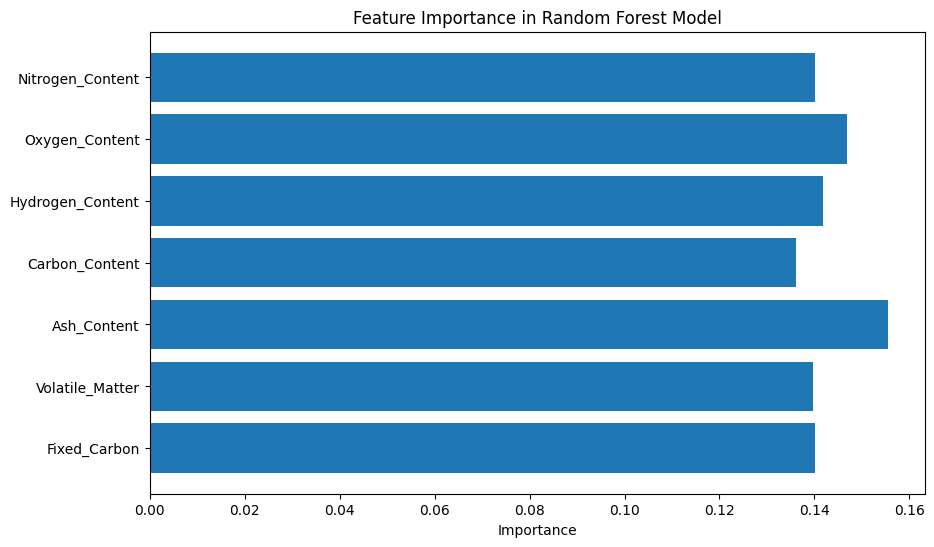

In [6]:
#Paper 10

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Generate a random dataset based on proximate and ultimate analysis parameters
np.random.seed(42)
n_samples = 1000

dataset = pd.DataFrame({
    'Fixed_Carbon': np.random.uniform(10, 30, n_samples),  # Proximate Analysis
    'Volatile_Matter': np.random.uniform(50, 80, n_samples),  # Proximate Analysis
    'Ash_Content': np.random.uniform(1, 10, n_samples),  # Proximate Analysis
    'Carbon_Content': np.random.uniform(30, 60, n_samples),  # Ultimate Analysis
    'Hydrogen_Content': np.random.uniform(5, 10, n_samples),  # Ultimate Analysis
    'Oxygen_Content': np.random.uniform(10, 50, n_samples),  # Ultimate Analysis
    'Nitrogen_Content': np.random.uniform(0.1, 5, n_samples),  # Ultimate Analysis
    'HHV': np.random.uniform(10, 30, n_samples)  # Target variable: Higher Heating Value
})

# Step 2: Preprocessing (Standardize the features)
X = dataset.drop('HHV', axis=1)  # Features
y = dataset['HHV']  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100)
rf_reg.fit(X_train, y_train)

# Step 5: Train Support Vector Regressor (SVM)
svr_reg = SVR(kernel='rbf')
svr_reg.fit(X_train, y_train)

# Step 6: Train Artificial Neural Network (ANN)
ann_reg = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
ann_reg.fit(X_train, y_train)

# Step 7: Evaluate the models
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"R²: {r2:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}")
    print('-' * 40)

# Predictions
y_pred_rf = rf_reg.predict(X_test)
y_pred_svr = svr_reg.predict(X_test)
y_pred_ann = ann_reg.predict(X_test)

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate Support Vector Regression
evaluate_model(y_test, y_pred_svr, "Support Vector Regression")

# Evaluate Artificial Neural Network
evaluate_model(y_test, y_pred_ann, "Artificial Neural Network")

# Step 8: Feature Importance for Random Forest
rf_importances = rf_reg.feature_importances_
features = X.columns

# Plot feature importances for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(features, rf_importances)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


Bio_oil_Yield - R²: -0.04, RMSE: 8.78
Viscosity - R²: -0.02, RMSE: 12.93
Calorific_Value - R²: -0.03, RMSE: 5.96
H_C_Ratio - R²: -0.03, RMSE: 0.28
O_C_Ratio - R²: 0.00, RMSE: 0.11


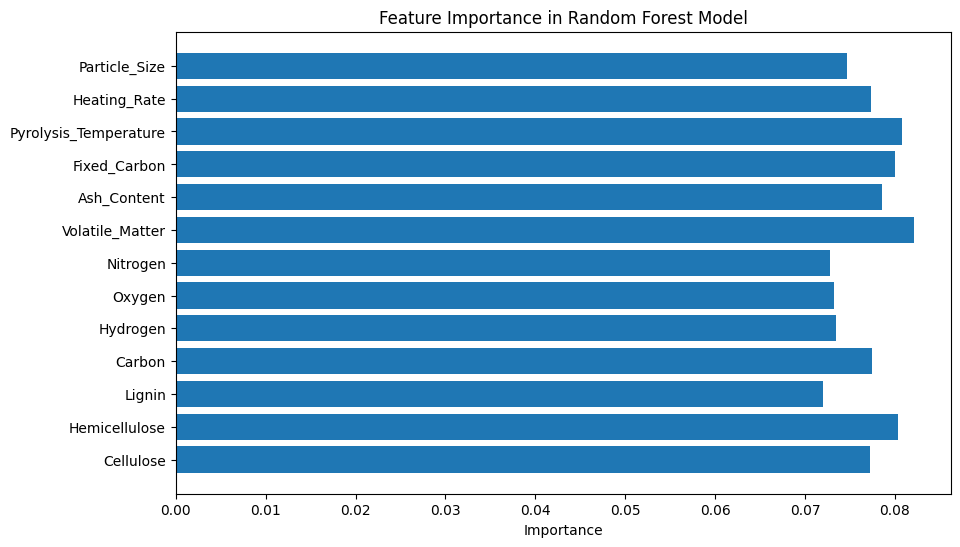

In [7]:
#Paper 17

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Generate a random dataset based on the parameters in the paper
np.random.seed(42)
n_samples = 1000

# Chemical Components
cellulose = np.random.uniform(30, 60, n_samples)
hemicellulose = np.random.uniform(10, 30, n_samples)
lignin = np.random.uniform(5, 20, n_samples)

# Ultimate Analysis
carbon = np.random.uniform(40, 60, n_samples)
hydrogen = np.random.uniform(5, 10, n_samples)
oxygen = np.random.uniform(10, 40, n_samples)
nitrogen = np.random.uniform(0.5, 2.5, n_samples)

# Proximate Analysis
volatile_matter = np.random.uniform(50, 80, n_samples)
ash_content = np.random.uniform(1, 10, n_samples)
fixed_carbon = np.random.uniform(10, 30, n_samples)

# Pyrolysis Conditions
pyrolysis_temp = np.random.uniform(400, 800, n_samples)
heating_rate = np.random.uniform(10, 50, n_samples)
particle_size = np.random.uniform(0.1, 5, n_samples)

# Targets: Bio-oil characteristics
bio_oil_yield = np.random.uniform(20, 50, n_samples)  # Bio-oil yield
viscosity = np.random.uniform(5, 50, n_samples)  # Viscosity of bio-oil
calorific_value = np.random.uniform(30, 50, n_samples)  # Calorific Value
hc_ratio = np.random.uniform(1, 2, n_samples)  # Hydrogen to Carbon ratio
oc_ratio = np.random.uniform(0.1, 0.5, n_samples)  # Oxygen to Carbon ratio

# Create a DataFrame
dataset = pd.DataFrame({
    'Cellulose': cellulose,
    'Hemicellulose': hemicellulose,
    'Lignin': lignin,
    'Carbon': carbon,
    'Hydrogen': hydrogen,
    'Oxygen': oxygen,
    'Nitrogen': nitrogen,
    'Volatile_Matter': volatile_matter,
    'Ash_Content': ash_content,
    'Fixed_Carbon': fixed_carbon,
    'Pyrolysis_Temperature': pyrolysis_temp,
    'Heating_Rate': heating_rate,
    'Particle_Size': particle_size,
    'Bio_oil_Yield': bio_oil_yield,
    'Viscosity': viscosity,
    'Calorific_Value': calorific_value,
    'H_C_Ratio': hc_ratio,
    'O_C_Ratio': oc_ratio
})

# Step 2: Define features (X) and targets (Y)
X = dataset[['Cellulose', 'Hemicellulose', 'Lignin', 'Carbon', 'Hydrogen', 'Oxygen', 'Nitrogen', 
             'Volatile_Matter', 'Ash_Content', 'Fixed_Carbon', 
             'Pyrolysis_Temperature', 'Heating_Rate', 'Particle_Size']]

# Targets to predict
Y = dataset[['Bio_oil_Yield', 'Viscosity', 'Calorific_Value', 'H_C_Ratio', 'O_C_Ratio']]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Predictions and Model Evaluation
y_pred = rf_model.predict(X_test)

# Evaluate each target separately
target_names = ['Bio_oil_Yield', 'Viscosity', 'Calorific_Value', 'H_C_Ratio', 'O_C_Ratio']
for i, target in enumerate(target_names):
    r2 = r2_score(y_test[target], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred[:, i]))
    print(f"{target} - R²: {r2:.2f}, RMSE: {rmse:.2f}")

# Step 6: Feature Importance
importances = rf_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()



Target: Biochar_Yield
RandomForest - R²: -0.05, RMSE: 8.72
SVR - R²: -0.00, RMSE: 8.52
XGBoost - R²: -0.30, RMSE: 9.71
MLP - R²: -0.10, RMSE: 8.93

Target: Bio_oil_Yield
RandomForest - R²: -0.10, RMSE: 9.24
SVR - R²: -0.01, RMSE: 8.85
XGBoost - R²: -0.24, RMSE: 9.84
MLP - R²: -0.15, RMSE: 9.45

Target: Gas_Yield
RandomForest - R²: -0.06, RMSE: 5.71
SVR - R²: -0.01, RMSE: 5.58
XGBoost - R²: -0.24, RMSE: 6.17
MLP - R²: -0.10, RMSE: 5.81

Target: HHV_Bio_oil
RandomForest - R²: -0.03, RMSE: 8.56
SVR - R²: 0.00, RMSE: 8.43
XGBoost - R²: -0.30, RMSE: 9.63
MLP - R²: -0.12, RMSE: 8.93


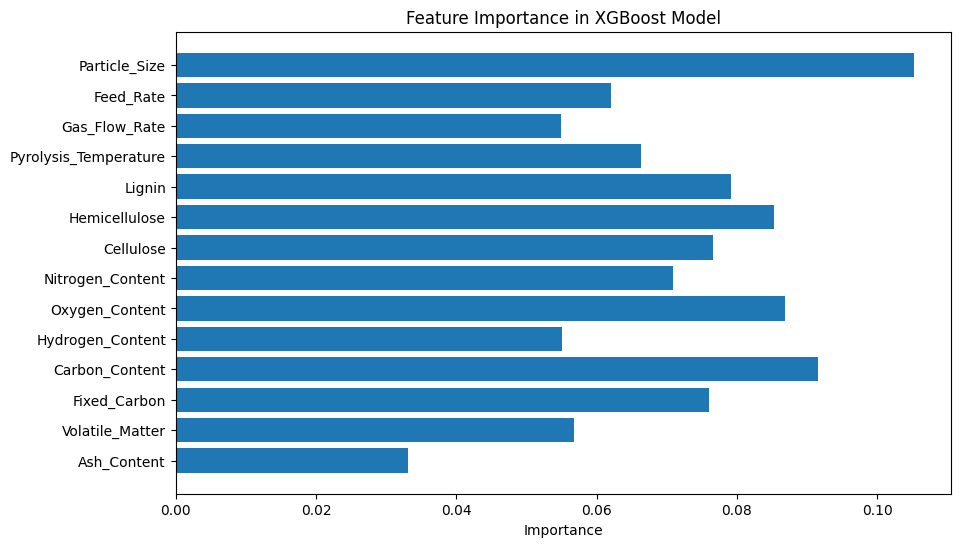

In [8]:
#Paper 20

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Generate a random dataset based on the parameters mentioned in the paper
np.random.seed(42)
n_samples = 1000

# Proximate Analysis
ash_content = np.random.uniform(1, 10, n_samples)
volatile_matter = np.random.uniform(50, 80, n_samples)
fixed_carbon = np.random.uniform(10, 30, n_samples)

# Ultimate Analysis
carbon_content = np.random.uniform(30, 60, n_samples)
hydrogen_content = np.random.uniform(5, 10, n_samples)
oxygen_content = np.random.uniform(10, 50, n_samples)
nitrogen_content = np.random.uniform(0.1, 5, n_samples)

# Biomass Composition
cellulose = np.random.uniform(30, 60, n_samples)
hemicellulose = np.random.uniform(10, 30, n_samples)
lignin = np.random.uniform(5, 20, n_samples)

# Pyrolysis Conditions
pyrolysis_temp = np.random.uniform(400, 800, n_samples)
gas_flow_rate = np.random.uniform(0.5, 2.5, n_samples)  # in L/min
feed_rate = np.random.uniform(10, 50, n_samples)  # in g/min
particle_size = np.random.uniform(0.1, 5, n_samples)  # in mm

# Targets: Biochar, Bio-oil, Gas Yield, HHV of Bio-oil
biochar_yield = np.random.uniform(10, 40, n_samples)  # Biochar yield
bio_oil_yield = np.random.uniform(20, 50, n_samples)  # Bio-oil yield
gas_yield = np.random.uniform(10, 30, n_samples)  # Gas yield
hhv_bio_oil = np.random.uniform(20, 50, n_samples)  # HHV of bio-oil

# Create a DataFrame
dataset = pd.DataFrame({
    'Ash_Content': ash_content,
    'Volatile_Matter': volatile_matter,
    'Fixed_Carbon': fixed_carbon,
    'Carbon_Content': carbon_content,
    'Hydrogen_Content': hydrogen_content,
    'Oxygen_Content': oxygen_content,
    'Nitrogen_Content': nitrogen_content,
    'Cellulose': cellulose,
    'Hemicellulose': hemicellulose,
    'Lignin': lignin,
    'Pyrolysis_Temperature': pyrolysis_temp,
    'Gas_Flow_Rate': gas_flow_rate,
    'Feed_Rate': feed_rate,
    'Particle_Size': particle_size,
    'Biochar_Yield': biochar_yield,
    'Bio_oil_Yield': bio_oil_yield,
    'Gas_Yield': gas_yield,
    'HHV_Bio_oil': hhv_bio_oil
})

# Step 2: Define features (X) and targets (Y)
X = dataset[['Ash_Content', 'Volatile_Matter', 'Fixed_Carbon', 'Carbon_Content', 'Hydrogen_Content', 
             'Oxygen_Content', 'Nitrogen_Content', 'Cellulose', 'Hemicellulose', 'Lignin', 
             'Pyrolysis_Temperature', 'Gas_Flow_Rate', 'Feed_Rate', 'Particle_Size']]

# Separate each target variable for training
targets = {
    'Biochar_Yield': dataset['Biochar_Yield'],
    'Bio_oil_Yield': dataset['Bio_oil_Yield'],
    'Gas_Yield': dataset['Gas_Yield'],
    'HHV_Bio_oil': dataset['HHV_Bio_oil']
}

# Step 3: Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Step 4: Define the models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Step 5: Train and evaluate models for each target variable
for target_name, target_values in targets.items():
    y_train, y_test = train_test_split(target_values, test_size=0.2, random_state=42)
    
    print(f"\nTarget: {target_name}")
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"{model_name} - R²: {r2:.2f}, RMSE: {rmse:.2f}")

# Step 6: Feature Importance for Random Forest and XGB
rf_model = models['RandomForest']
xgb_model = models['XGBoost']

rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

features = X.columns

# Plot feature importances for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(features, rf_importances)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

# Plot feature importances for XGB
plt.figure(figsize=(10, 6))
plt.barh(features, xgb_importances)
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost Model')
plt.show()



In [9]:
#Paper 24

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import shap

# Step 1: Generate a random dataset based on the parameters in the paper
np.random.seed(42)
n_samples = 1000

# Biomass Characteristics: Ultimate Analysis
carbon = np.random.uniform(30, 60, n_samples)
hydrogen = np.random.uniform(5, 10, n_samples)
oxygen = np.random.uniform(10, 50, n_samples)
nitrogen = np.random.uniform(0.1, 5, n_samples)

# Proximate Analysis
fixed_carbon = np.random.uniform(10, 30, n_samples)
volatile_matter = np.random.uniform(50, 80, n_samples)
ash_content = np.random.uniform(1, 10, n_samples)

# Pyrolysis Conditions
pyrolysis_temp = np.random.uniform(400, 800, n_samples)  # Pyrolysis Temperature (PT)
particle_size = np.random.uniform(0.1, 5, n_samples)  # Particle Size (PS)
flow_rate = np.random.uniform(0.5, 2.5, n_samples)  # Nitrogen Flow Rate (FR)

# Target Variables: Oxygenated Components in Bio-oil
acids = np.random.uniform(1, 10, n_samples)  # Acids (e.g., acetic acid)
phenols = np.random.uniform(5, 15, n_samples)  # Phenols
ketones_aldehydes = np.random.uniform(3, 12, n_samples)  # Ketones and Aldehydes

# Create a DataFrame
dataset = pd.DataFrame({
    'Carbon': carbon,
    'Hydrogen': hydrogen,
    'Oxygen': oxygen,
    'Nitrogen': nitrogen,
    'Fixed_Carbon': fixed_carbon,
    'Volatile_Matter': volatile_matter,
    'Ash_Content': ash_content,
    'Pyrolysis_Temperature': pyrolysis_temp,
    'Particle_Size': particle_size,
    'Flow_Rate': flow_rate,
    'Acids': acids,
    'Phenols': phenols,
    'Ketones_Aldehydes': ketones_aldehydes
})

# Step 2: Define features (X) and target variables (Y)
X = dataset[['Carbon', 'Hydrogen', 'Oxygen', 'Nitrogen', 'Fixed_Carbon', 'Volatile_Matter', 
             'Ash_Content', 'Pyrolysis_Temperature', 'Particle_Size', 'Flow_Rate']]

# Separate target variables
Y_acids = dataset['Acids']
Y_phenols = dataset['Phenols']
Y_ketones_aldehydes = dataset['Ketones_Aldehydes']

# Step 3: Train-test split
X_train, X_test, y_train_acids, y_test_acids = train_test_split(X, Y_acids, test_size=0.2, random_state=42)
X_train, X_test, y_train_phenols, y_test_phenols = train_test_split(X, Y_phenols, test_size=0.2, random_state=42)
X_train, X_test, y_train_ketones_aldehydes, y_test_ketones_aldehydes = train_test_split(X, Y_ketones_aldehydes, test_size=0.2, random_state=42)

# Step 4: Define XGBRegressor with Bayesian Optimization for hyperparameter tuning
xgb_model = XGBRegressor(random_state=42)

# Define the hyperparameter search space
param_space = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 10),
    'subsample': (0.6, 1.0)
}

# Perform Bayesian Optimization
opt = BayesSearchCV(xgb_model, param_space, n_iter=32, scoring='neg_mean_squared_error', cv=3, random_state=42)
opt.fit(X_train, y_train_acids)

# Get the best model after optimization
best_xgb_model_acids = opt.best_estimator_

# Step 5: Train the models for each target
best_xgb_model_acids.fit(X_train, y_train_acids)
best_xgb_model_phenols = opt.best_estimator_
best_xgb_model_phenols.fit(X_train, y_train_phenols)
best_xgb_model_ketones_aldehydes = opt.best_estimator_
best_xgb_model_ketones_aldehydes.fit(X_train, y_train_ketones_aldehydes)

# Step 6: Predictions and Model Evaluation
def evaluate_model(model, y_test, y_pred, target_name):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{target_name} - R²: {r2:.2f}, RMSE: {rmse:.2f}")

# Acids prediction
y_pred_acids = best_xgb_model_acids.predict(X_test)
evaluate_model(best_xgb_model_acids, y_test_acids, y_pred_acids, "Acids")

# Phenols prediction
y_pred_phenols = best_xgb_model_phenols.predict(X_test)
evaluate_model(best_xgb_model_phenols, y_test_phenols, y_pred_phenols, "Phenols")

# Ketones and Aldehydes prediction
y_pred_ketones_aldehydes = best_xgb_model_ketones_aldehydes.predict(X_test)
evaluate_model(best_xgb_model_ketones_aldehydes, y_test_ketones_aldehydes, y_pred_ketones_aldehydes, "Ketones and Aldehydes")

# Step 7: Feature Importance and SHAP Analysis
explainer_acids = shap.Explainer(best_xgb_model_acids)
shap_values_acids = explainer_acids(X_test)

# SHAP summary plot for Acids prediction
shap.summary_plot(shap_values_acids, X_test, feature_names=X.columns)

# SHAP Analysis for Phenols and Ketones can be repeated similarly


Acids - R²: -0.51, RMSE: 3.27
Phenols - R²: -0.82, RMSE: 3.95
Ketones and Aldehydes - R²: -0.01, RMSE: 2.83
